# 'Basic Model of ARIMA'

to try out how ARIMA first i tried it on toy dataset which is a staionary sign wave

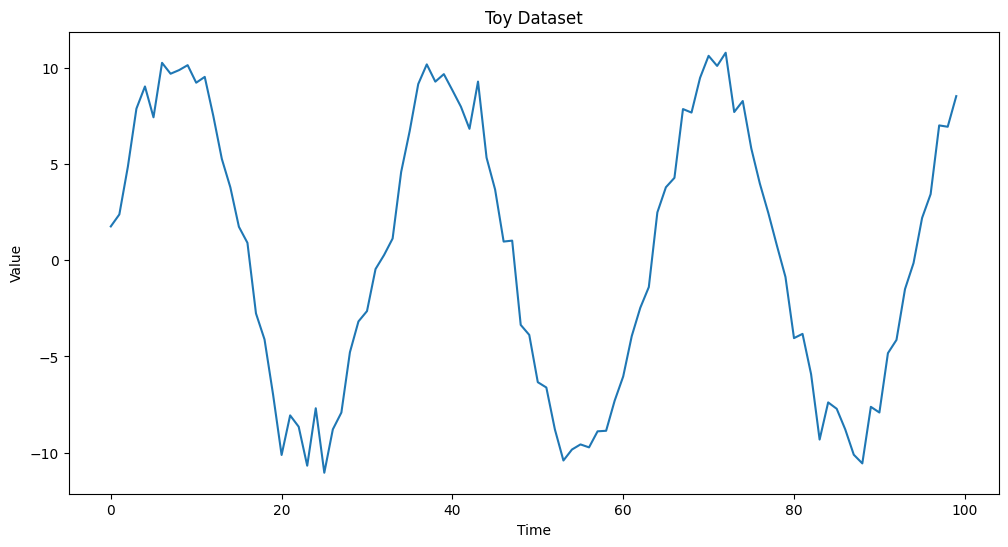

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Generate a toy dataset with a sine wave pattern and some noise
np.random.seed(0)
n_points = 100
time = np.arange(0, n_points)
toy_data = 10 * np.sin(0.2 * time) + np.random.normal(0, 1, n_points)

# Create a DataFrame with a time index
toy_df = pd.DataFrame({'value': toy_data}, index=time)

# Visualize the toy dataset
plt.figure(figsize=(12, 6))
plt.plot(toy_df.index, toy_df['value'])
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Toy Dataset')
plt.show()


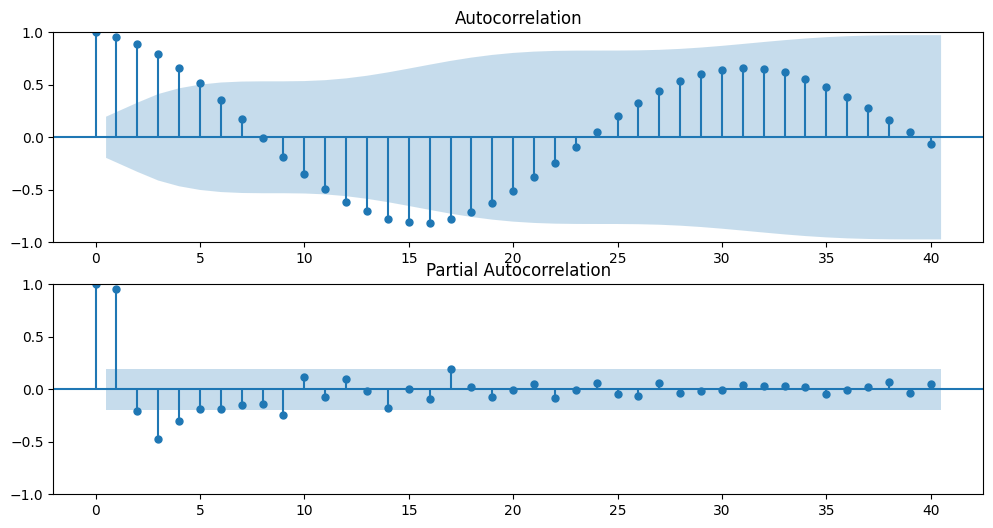

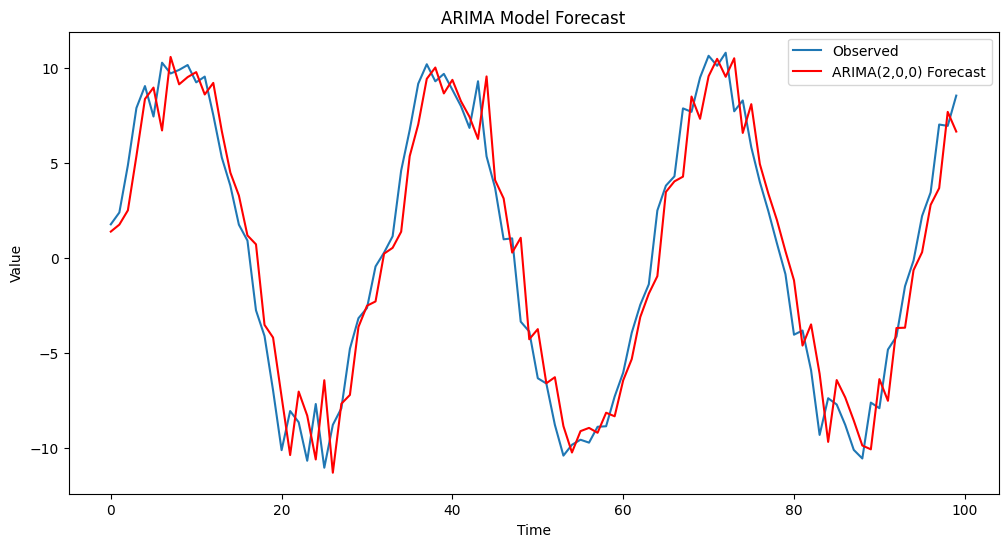

In [ ]:
import statsmodels.api as sm

# Step 1: Make the time series stationary (if necessary)
# In this case, the dataset is already stationary, so no differencing is needed.

# Step 2: Determine the order of the ARIMA model (p, d, q)
# We'll use ACF and PACF plots to make an initial selection.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(211)
plot_acf(toy_df['value'], lags=40, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(toy_df['value'], lags=40, ax=ax2)
plt.show()

# Based on the ACF and PACF plots, we'll start with an ARIMA(2,0,0) model (p=2, d=0, q=0).

# Step 3: Fit the ARIMA model
order = (2, 0, 0)  # ARIMA(2,0,0) order
arima_model = sm.tsa.ARIMA(toy_df['value'], order=order)
arima_result = arima_model.fit()

# Step 4: Model evaluation (in-sample forecast)
# You can use the forecast method to make predictions within the training data range.
predictions = arima_result.predict(start=0, end=n_points - 1, dynamic=False)

# Visualize the model's predictions
plt.figure(figsize=(12, 6))
plt.plot(toy_df.index, toy_df['value'], label='Observed')
plt.plot(toy_df.index, predictions, label='ARIMA(2,0,0) Forecast', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()


#Big data On Germany renewable energy price predction traiinng on 2021 data and forecasting on 2022 data

##Preprocessing data

In [10]:
price_df_2021 = pd.read_excel("/content/Gro_handelspreise_202110270000_202112312359.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [21]:
price_df_2021_ger = price_df_2021.iloc[6:,:3]

In [22]:
price_df_2021_ger

,Datenkategorie: Großhandelspreise,Unnamed: 1,Unnamed: 2
6,27.10.2021,00:00,91.33
7,27.10.2021,01:00,85.4
8,27.10.2021,02:00,69.92
9,27.10.2021,03:00,66.8
10,27.10.2021,04:00,85.36
...,...,...,...
1586,31.12.2021,19:00,32.49
1587,31.12.2021,20:00,0.18
1588,31.12.2021,21:00,0.08
1589,31.12.2021,22:00,5.1


###Convesting into data and time module

In [23]:
price_df_2021_ger=price_df_2021_ger.rename(columns={'Datenkategorie: Großhandelspreise':"Date","Unnamed: 1":"Time","Unnamed: 2":"Deutschland/Luxemburg[€/MWh]"})
price_df_2021_ger.isnull().sum()

Date                            0
Time                            0
Deutschland/Luxemburg[€/MWh]    0
dtype: int64

In [26]:
price_df_2021_ger["Deutschland/Luxemburg[€/MWh]"] = price_df_2021_ger["Deutschland/Luxemburg[€/MWh]"].astype(float)

In [90]:

dt_series = price_df_2021_ger['Date'] + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in price_df_2021_ger['Time']], index=price_df_2021_ger.index)
date_format = '%d.%m.%Y %H:%M'
dt_series = pd.to_datetime(dt_series, format=date_format)
dt_series

6      2021-10-27 00:00:00
7      2021-10-27 01:00:00
8      2021-10-27 02:00:00
9      2021-10-27 03:00:00
10     2021-10-27 04:00:00
               ...        
1586   2021-12-31 19:00:00
1587   2021-12-31 20:00:00
1588   2021-12-31 21:00:00
1589   2021-12-31 22:00:00
1590   2021-12-31 23:00:00
Length: 1585, dtype: datetime64[ns]

In [91]:
df = price_df_2021_ger.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)
df['DateTime']

6      2021-10-27 00:00:00
7      2021-10-27 01:00:00
8      2021-10-27 02:00:00
9      2021-10-27 03:00:00
10     2021-10-27 04:00:00
               ...        
1586   2021-12-31 19:00:00
1587   2021-12-31 20:00:00
1588   2021-12-31 21:00:00
1589   2021-12-31 22:00:00
1590   2021-12-31 23:00:00
Name: DateTime, Length: 1585, dtype: datetime64[ns]

In [100]:

# Assuming your datetime column is named 'DateTime'
# Filter the data to select only rows with time '00:00:00'
filtered_data = df[df['DateTime'].dt.time == pd.to_datetime('00:00:00').time()]



In [101]:
filtered_data

,DateTime,Deutschland/Luxemburg[€/MWh]
6,2021-10-27,91.33
30,2021-10-28,133.02
54,2021-10-29,94.98
78,2021-10-30,75.05
102,2021-10-31,56.14
...,...,...
1471,2021-12-27,95.79
1495,2021-12-28,74.40
1519,2021-12-29,112.06
1543,2021-12-30,73.08


In [102]:
filtered_data.set_index('DateTime', inplace=True)

# Ensure the DataFrame is sorted by DateTime
filtered_data = filtered_data.sort_index()

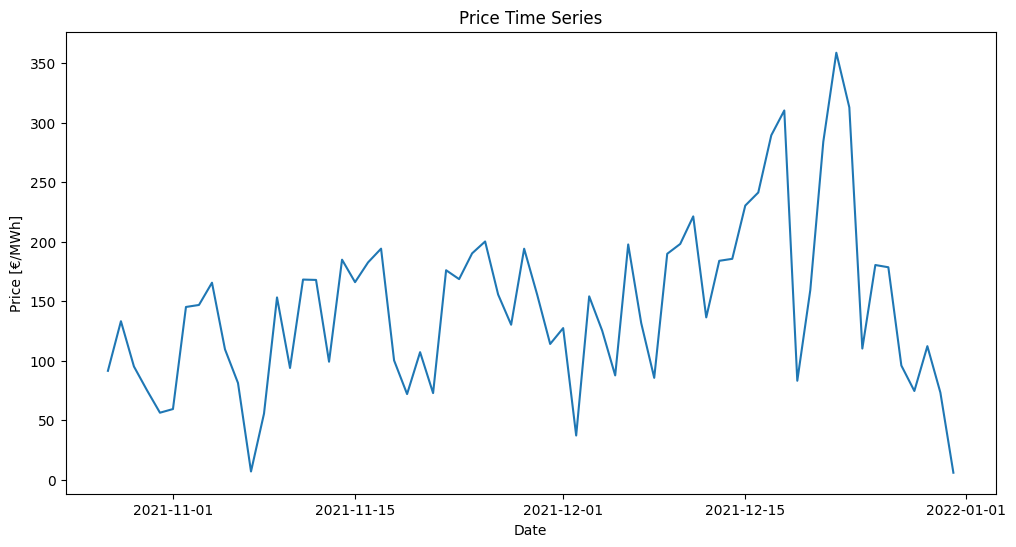

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Deutschland/Luxemburg[€/MWh]'])
plt.title('Price Time Series')
plt.xlabel('Date')
plt.ylabel('Price [€/MWh]')
plt.show()

##Building the Model

Stationarity Check:
ARIMA models work best on stationary time series data. Check for stationarity using the Dickey-Fuller test or visual inspection. If the data is not stationary, you may need to perform differencing.

In [97]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(filtered_data['Deutschland/Luxemburg[€/MWh]'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])


ADF Statistic: -1.6013133548151643
p-value: 0.4829336945071503
Critical Values: {'1%': -3.5552728880540942, '5%': -2.9157312396694217, '10%': -2.5956695041322315}


In [104]:
# First-order differencing
filtered_data_diff = filtered_data.diff().dropna()

# Re-run ADF test
result_diff = adfuller(filtered_data_diff['Deutschland/Luxemburg[€/MWh]'])
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])
print('Critical Values after differencing:', result_diff[4])
  # First-order differencing


ADF Statistic after differencing: -1.6430609436790617
p-value after differencing: 0.4606618122002051
Critical Values after differencing: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}


In [105]:
# Second-order differencing
filtered_data_diff = filtered_data.diff().diff().dropna()

# Re-run ADF test
result_diff = adfuller(filtered_data_diff['Deutschland/Luxemburg[€/MWh]'])
print('ADF Statistic after second-order differencing:', result_diff[0])
print('p-value after second-order differencing:', result_diff[1])
print('Critical Values after second-order differencing:', result_diff[4])


ADF Statistic after second-order differencing: -4.7273796124361285
p-value after second-order differencing: 7.473168566281399e-05
Critical Values after second-order differencing: {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}


In [107]:
from statsmodels.tsa.arima.model import ARIMA
p = 2  # Example value for p
d = 1  # Example value for d
q = 2  # Example value for q

model = ARIMA(filtered_data_diff, order=(p, 2, q))  # Replace p and q with your selected orders
model_fit = model.fit()

# Model Evaluation
# Examine residuals, diagnostic plots, and performance metrics




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [111]:
import scipy.stats
# Forecasting
forecast_horizon = 12  # Example: Forecast the next 12 time steps
forecast = model_fit.forecast(steps=forecast_horizon)




In [112]:
# Calculate the residuals
residuals = filtered_data_diff['Deutschland/Luxemburg[€/MWh]'] - model_fit.fittedvalues

# Calculate the standard error (stderr) of the forecast
stderr = residuals.std()


In [113]:
# Calculate confidence intervals manually
alpha = 0.05  # You can adjust the confidence level (e.g., 0.05 for 95% confidence)
z_critical = scipy.stats.norm.ppf(1 - alpha / 2)  # Z-score for the desired confidence level
margin_of_error = z_critical * stderr
lower_bound = forecast - margin_of_error
upper_bound = forecast + margin_of_error


##Forcasting the future  with confidence intervals

<ipython-input-114-f5614c29c7ef>:8: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=filtered_data.index[-1], periods=forecast_horizon+1, closed='right')


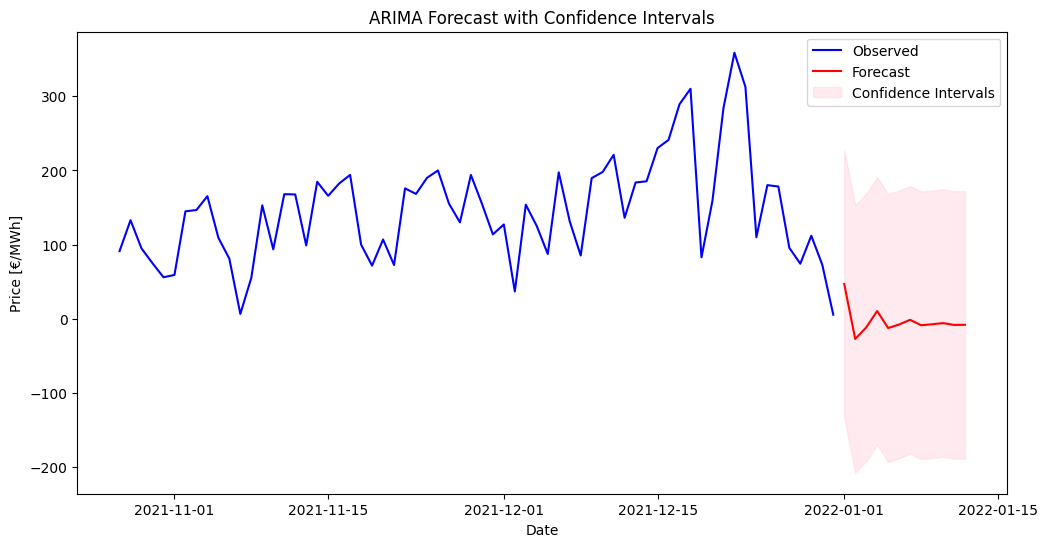

In [114]:
import matplotlib.pyplot as plt

# Plot the observed data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['Deutschland/Luxemburg[€/MWh]'], label='Observed', color='blue')

# Plot the forecast
forecast_dates = pd.date_range(start=filtered_data.index[-1], periods=forecast_horizon+1, closed='right')
plt.plot(forecast_dates, forecast, label='Forecast', color='red')

# Plot the confidence intervals
plt.fill_between(forecast_dates, lower_bound, upper_bound, color='pink', alpha=0.3, label='Confidence Intervals')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Price [€/MWh]')
plt.title('ARIMA Forecast with Confidence Intervals')

# Add a legend
plt.legend()

# Show the plot
plt.show()
